# Homework 4

## References

+ Lectures 13-16 (inclusive).


## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

In [73]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

## Student details

+ **First Name:** Mihir 
+ **Last Name:** Nadig
+ **Email:** mnadig@purdue.edu

# Problem 1 - Estimating the mechanical properties of a plastic material from molecular dynamics simulations

First, make sure that [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/stress_strain.txt) dataset is visible from this Jupyter notebook.
You may achieve this by either:

+ Downloading the data file, and then mannually upload it on Google Colab. The easiest way is to click on the folder icon on the left of the browser window and click on the upload button (or just drag and drop the file). Some other options are [here](https://colab.research.google.com/notebooks/io.ipynb).
+ Downloading the file to the working directory of this notebook with this code:

In [74]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/stress_strain.txt"
download(url)

It's up to you what you choose to do.
If the file is in the right place, the following code should work:

In [75]:
data =  np.loadtxt('stress_strain.txt')
print(data.shape)

(1001, 2)


The dataset was generated using a molecular dynamics simulation of a plastic material (thanks to [Professor Alejandro Strachan](https://engineering.purdue.edu/MSE/people/ptProfile?id=33239) for sharing the data!).
Specifically, Strachan's group did the following:
- They took a rectangular chunk of the material and marked the position of each one of its atoms;
- They started applying a tensile force along one dimension.
The atoms are coupled together through electromagnetic forces and they must all satisfy Newton's law of motion.
- For each value of the applied tensile force they marked the stress (force be unit area) in the middle of the materail and the corresponding strain of the material (percent enlogation in the pulling direction).
- Eventually the material entered the plastic regime and then it broke.
Here is a visualization of the data:

(1001,)


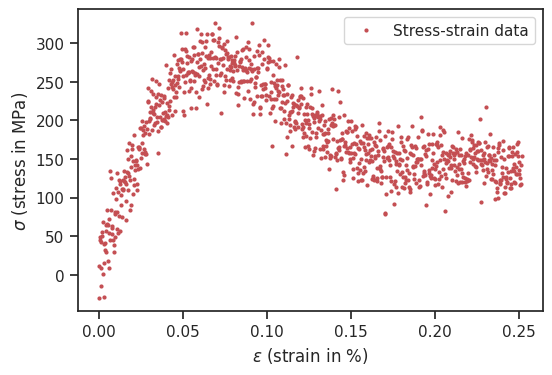

In [76]:
# Strain 
x = data[:, 0]
# Stress in MPa
y = data[:, 1]

#Uncontaminated for later 
x1 = data[:, 0]
y1 = data[:, 1]


print(x.shape)

plt.figure()
plt.plot(
    x,
    y,
    'ro',
    markersize=2,
    label='Stress-strain data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best');

Note that for each particular value of the strain, you don't necessarily get a unique stress.
This is because in molecular dynamics the atoms are jiggling around due to thermal effects.
So there is always this "jiggling" noise when you are trying to measure the stress and the strain.
We would like to process this noise in order to extract what is known as the [stress-strain curve](https://en.wikipedia.org/wiki/Stress–strain_curve) of the material.
The stress-strain curve is a macroscopic property of the the material which is affeted by the fine structure, e.g., the chemical bonds, the crystaline structure, any defects, etc.
It is a required input to mechanics of materials.

## Part A - Fitting the stress-strain curve in the elastic regime
The very first part of the stress-strain curve should be linear.
It is called the *elastic regime*.
In that region, say $\epsilon < \epsilon_l=0.04$, the relationship between stress and strain is:

$$
\sigma(\epsilon) = E\epsilon.
$$

The constant $E$ is known as the *Young modulus* of the material.
Assume that you measure $\epsilon$ without any noise, but your measured $\sigma$ is noisy.

### Subpart A.I
First, extract the relevant data for this problem, split it into training and validation datasets, and visualize the training and validation datasets using different colors.

(159,)
(159,)


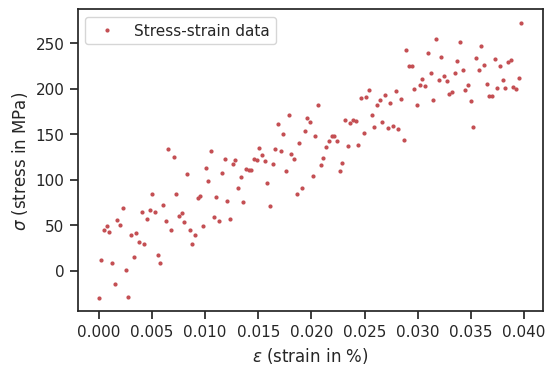

In [77]:
# The point at which the stress-strain curve stops being linear
epsilon_l = 0.04
# Relevant data (this is nice way to get the linear part of the stresses and straints)
x_rel = x[x < 0.04]
y_rel = y[x < 0.04]

print(x_rel.shape)
print(y_rel.shape)

# Visualize to make sure you have the right data
plt.figure()
plt.plot(
    x_rel,
    y_rel,
    'ro',
    markersize=2,
    label='Stress-strain data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best');

Split your data into training and validation.

**Hint:** You may use [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) if you wish.

In [78]:
# Split the data into training and validation datasets
# Hint: Consult the lecture notes
# from 13.5: x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_rel, y_rel, test_size=0.20)

print(x_train.shape)
print(y_train.shape)

(127,)
(127,)


Use the following to visualize your split:

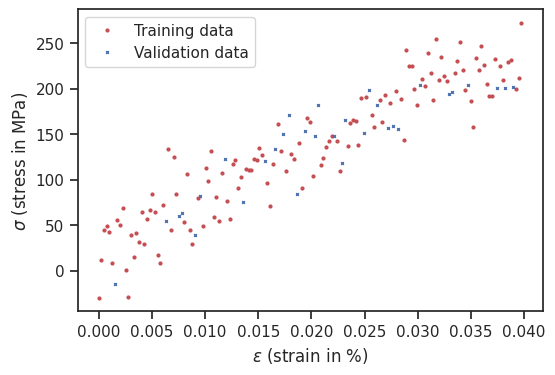

In [79]:
plt.figure()
plt.plot(
    x_train,
    y_train,
    'ro',
    markersize=2,
    label='Training data'
)
plt.plot(
    x_valid,
    y_valid,
    'bx',
    markersize=2,
    label='Validation data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best');

### Subpart A.II
Perform Bayesian linear regression with the evidence approximation to estimate the noise variance and the hyperparameters of the prior.

In [80]:
# Your code here
# Design Matrix Function 
def get_polynomial_design_matrix(x, degree):
    """Return the polynomial design matrix of ``degree`` evaluated at ``x``.
    
    Arguments:
    x      -- A 2D array with only one column.
    degree -- An integer greater than zero.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    cols = []
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)


In [81]:
from sklearn.linear_model import BayesianRidge

#Linear Fit 
degree = 1

print(x_train.shape)

#Design Matrix 
Phi = get_polynomial_design_matrix(x_train[:, None], degree)
print(Phi.shape)

#define model
model = BayesianRidge(
    fit_intercept=False
).fit(Phi, y_train)


(127,)
(127, 2)


In [82]:
#Sigma 

sigma = np.sqrt(1.0 / model.alpha_)
print(f'sigma = {sigma:1.2f}')

#Alpha 
alpha = np.sqrt(1/model.lambda_)
print(f'alpha = {alpha:1.2f}')

sigma = 26.83
alpha = 3923.05


In [83]:
#Find the weights 
m = model.coef_
print(f"Posterior mean w: {m}")

#Covariance Matrix 
S = model.sigma_
print(f"Posterior covariance w: {S}")



Posterior mean w: [  25.495 5544.374]
Posterior covariance w: [[ 2.079e+01 -7.765e+02]
 [-7.765e+02  3.988e+04]]


### Subpart A.III
Calculate the mean square error of the validation data.

In [84]:
# your code here
#13.5 first time I saw it but not bayesian linear regression 

Phi_poly_test = get_polynomial_design_matrix(
    x_valid[:, None],
    degree)
#print(Phi_poly_test.shape)

y_test_predict = Phi_poly_test @ m

mse = np.mean((y_test_predict - y_valid) ** 2)
print(f'MSE = {mse:1.2f}')

# Just for me checking to see if model is any good!
#mu = y_train.mean()
#MSE_simplest = np.mean((y_valid - mu) ** 2)
#print(f'MSE_simplest = {MSE_simplest:1.2f}')
#RMSE_poly = mse / MSE_simplest
#print(f'RMSE_poly = {RMSE_poly:1.2f}')

MSE = 682.87


### Subpart A.IV
Make the observations vs predictions plot for the validation data.

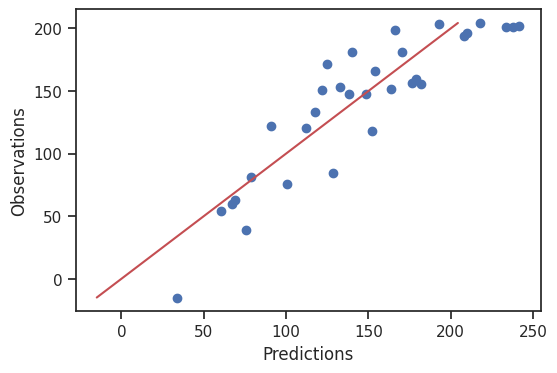

In [85]:
# your code here
Phi_valid = get_polynomial_design_matrix(
    x_valid[:, None],
    degree)

y_predict, y_std = model.predict(
    Phi_valid,
    return_std=True)

#Plotting 
fig, ax = plt.subplots()
ax.plot(y_predict, y_valid, 'o')
yys = np.linspace(
    y_valid.min(),
    y_valid.max(),
    100)
ax.plot(yys, yys, 'r-')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

### Subpart A.V
Compute and plot the standarized errors for the validation data.

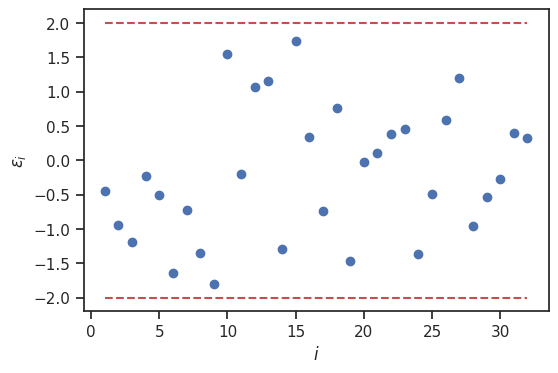

In [86]:
# your code here
eps = (y_valid - y_predict) / y_std

idx = np.arange(1, eps.shape[0] + 1)

fig, ax = plt.subplots()
ax.plot(idx, eps, 'o', label='Standarized errors')
ax.plot(idx, -2 * np.ones(eps.shape[0]), 'r--')
ax.plot(idx, 2 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$');

### Subpart A.VI
Make the quantile-quantile plot of the standarized errors.

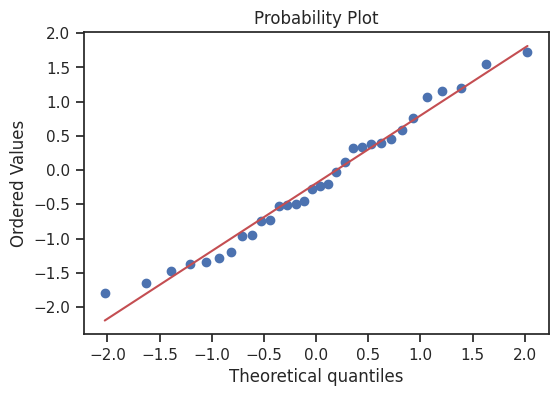

In [87]:
# your code here
fig, ax = plt.subplots()
st.probplot(eps, dist=st.norm, plot=ax);

### Subpart A.VII
Visualize your epistemic and the aleatory uncertainty about the stress-strain curve in the elastic regime.

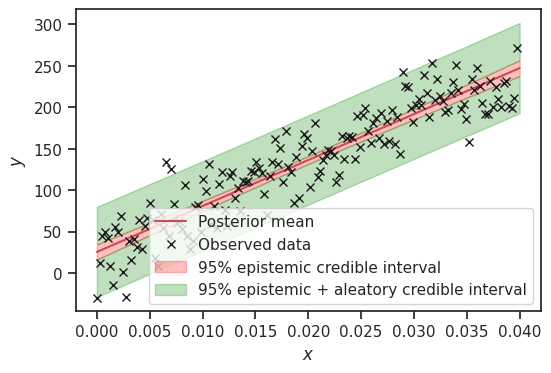

In [88]:
# your code here
# 14_4 example code?
xx = np.linspace(-0, .04, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)

# Predict with model
yy_mean, yy_measured_std = model.predict(
    Phi_xx,
    return_std=True
)

# Extract epistemic predictive standard deviation
yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
# Epistemic 95% credible interval
yy_le = yy_mean - 2.0 * yy_std
yy_ue = yy_mean + 2.0 * yy_std

# Epistemic + aleatory 95% credible interval
yy_lae = yy_mean - 2.0 * yy_measured_std
yy_uae = yy_mean + 2.0 * yy_measured_std

# The true response
# yy_true = w0_true + w1_true * xx + w2_true * xx ** 2

# Plot
fig, ax = plt.subplots()
ax.plot(xx, yy_mean, 'r', label="Posterior mean")
ax.fill_between(
    xx,
    yy_le,
    yy_ue,
    color='red',
    alpha=0.25,
    label="95% epistemic credible interval"
)
ax.fill_between(
    xx,
    yy_lae,
    yy_le,
    color='green',
    alpha=0.25
)
ax.fill_between(
    xx,
    yy_ue,
    yy_uae,
    color='green',
    alpha=0.25,
    label="95% epistemic + aleatory credible interval"
)
#Which Data should I use? All
ax.plot(x_rel, y_rel, 'kx', label='Observed data')
# ax.plot(xx, yy_true, "--", label="True response")
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc="best");


### Subpart A. VIII
Visualize the posterior of the Young modulus E conditioned on the data.

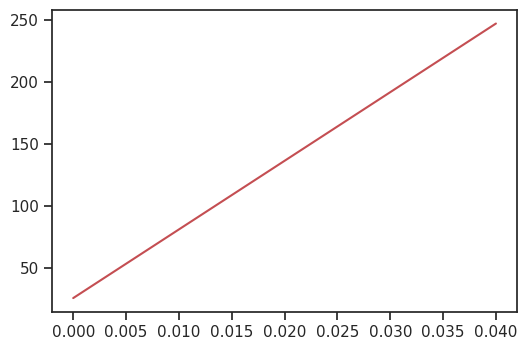

In [89]:
# your code here
fig, ax = plt.subplots()
ax.plot(xx, yy_mean, 'r', label="Posterior mean");



### Subpart A.IX
Take five samples of stress-strain curve in the elastic regime and visualize them.

(2,)
(2, 2)


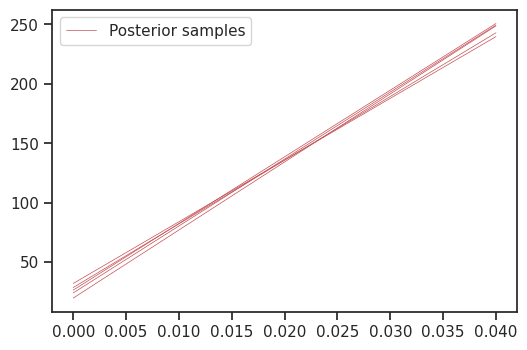

In [90]:
# your code here

Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
print(m.shape)
print(S.shape)
w_post = st.multivariate_normal(mean=m, cov=S)

# Plotting 
fig, ax = plt.subplots()
for _ in range(5):
    w_sample = w_post.rvs()
    yy_sample = Phi_xx @ w_sample
    ax.plot(xx, yy_sample, 'r', lw=0.5)
ax.plot([], [], "r", lw=0.5, label="Posterior samples")
plt.legend(loc="best");



### Subpart A.X

Find the 95% centered credible interval for the Young modulus $E$.

In [91]:
# your code here
#Credible interval of sigma divided by episilon 


lower_ym = st.linregress(xx, yy_le).slope
higher_ym = st.linregress(xx, yy_ue).slope

print(f'Credible Interval(Epistemic Uncertainty): {lower_ym:.2f} to {higher_ym:.2f}')

Credible Interval(Epistemic Uncertainty): 5533.30 to 5555.45


### Subpart A.XI
If you had to pick a single value for the Young modulus $E$, what would it be and why?

In [92]:
# your code here
#Slope of the mean of the mean of the model. 
slope = m[1]
print(f'Youngs Modulus: {slope:.2f}')

Youngs Modulus: 5544.37


*Your answer here*

5220.18 <br>

Reasoning shown in code block below. I used the mean of the model. 

## Part B - Estimate the ultimate strength

The pick of the stress-strain curve is known as the ultimate strength.
We will like to estimate it.

### Subpart B.I - Extract training and validation data

Extract training and validation data from the entire dataset.

In [93]:
# your code here - Repeat as many text and code blocks as you like

x_train, x_valid, y_train, y_valid = train_test_split(x1, y1, test_size=0.20)
print(x.shape)
print(y.shape)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)


(1001,)
(1001,)
(800,)
(800,)
(201,)
(201,)


Use the following to visualize your split:

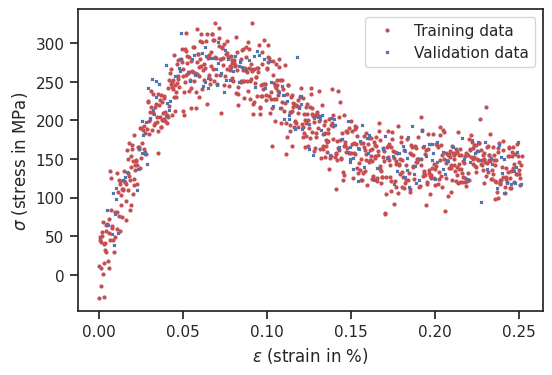

In [94]:
plt.figure()
plt.plot(
    x_train,
    y_train,
    'ro',
    markersize=2,
    label='Training data'
)
plt.plot(
    x_valid,
    y_valid,
    'bx',
    markersize=2,
    label='Validation data'
)
plt.xlabel('$\epsilon$ (strain in %)')
plt.ylabel('$\sigma$ (stress in MPa)')
plt.legend(loc='best');

### Subpart B.II - Model the entire stress-strain relationship.
To do this, we will set up a generalized linear model that can capture the entire stress-strain relationship.
Remember, you can use any model you want as soon as:
+ it is linear in the parameters to be estimated,
+ it clearly has a well-defined elastic regime (see Part A).

I am going to help you set up the right model.
We are goint to use the [Heavide step function](https://en.wikipedia.org/wiki/Heaviside_step_function) to turn on or off models for various ranges of $\epsilon$. The idea is quite simple: We will use a linear model for the elastic regime and we are going to turn to a non-linear model for the non-linear regime.
Here is a model that has the right form in the elastic regime and an arbitrary form in the non-linear regime:

$$
f(\epsilon;E,\mathbf{w}_g) = E\epsilon \left[(1 - H(\epsilon - \epsilon_l)\right] + g(\epsilon;\mathbf{w}_g)H(\epsilon - \epsilon_l),
$$

where

$$
H(x) = \begin{cases}
0,\;\text{if}\;x < 0\\
1,\;\text{otherwise},
\end{cases}
$$

and $g$ is any function linear in the parameters $\mathbf{w}_g$.

You can use any model you like for the non-linear regime, but let's use a polynomial of degree $d$:

$$
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i.
$$

The full model can be expressed as:

$$
\begin{split}
f(\epsilon) &= 
\begin{cases}
h(\epsilon) = E \epsilon,\ \epsilon < \epsilon_l, \\
g(\epsilon) = \sum_{i=0}^{d} w_i \epsilon^i, \epsilon \geq \epsilon_l
\end{cases}\\
&= E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
\end{split}
$$

We could proceed with this model, but there is a small problem: It is discontinuous at $\epsilon = \epsilon_l$.
This is unphysical. We can do better than that!

To make the model nice, we force the $h$ and $g$ to match up to the first derivative, i.e., we demand that:

$$
\begin{split}
h(\epsilon_l) &= g(\epsilon_l)\\
h'(\epsilon_l) &= g'(\epsilon_l).
\end{split}
$$

The reason we include the first derivative is so that we don't have a kink in the stress-strain. That would also be unphysical.
The two equations above become:

$$
\begin{split}
E\epsilon_l &= \sum_{i=0}^dw_i\epsilon_l^i\\
E &= \sum_{i=1}^diw_i\epsilon_l^{i-1}.
\end{split}
$$

We can use these two equations to eliminate two weights.
Let's eliminate $w_0$ and $w_1$.
All you have to do is express them in terms of $E$ and $w_2,\dots,w_d$.
So, there remain $d$ parameters to estimate.
Let's get back to the stress-strain model.

Our stress-strain model was:

$$
f(\epsilon) = E\epsilon \left(1 - H(\epsilon - \epsilon_l)\right) + \sum_{i=0}^{d} w_i \epsilon^iH(\epsilon - \epsilon_l).
$$

We can now use the expressions for $w_0$ and $w_1$ to rewrite this using only all the other 
parameters.
I am going to spare you the details...
The end result is:

$$
f(\epsilon) = E\epsilon + \sum_{i=2}^dw_i\left[(i-1)\epsilon_{l}^{i} - i \epsilon \epsilon_{l}^{i-1} + \epsilon^i\right]H(\epsilon - \epsilon_l).
$$

Okay.
This is still a generalized linear model. This is nice.
Write code for the design matrix:

In [95]:
# Complete this code to make your model:
def compute_design_matrix(Epsilon, epsilon_l, d):
    """Compute the design matrix for the stress-strain curve problem.
    
    Arguments:
        Epsilon     -     A 1D array of dimension N.
        epsilon_l   -     The strain signifying the end of the elastic regime.
        d           -     The polynomial degree.
    
    Returns:
        A design matrix N x d
    """
    # Sanity check
    assert isinstance(Epsilon, np.ndarray)
    assert Epsilon.ndim == 1, 'Pass the array as epsilon.flatten(), if it is two dimensional'
    n = Epsilon.shape[0]
    # The design matrix:
    Phi = np.ndarray((n, d))
    # The step function evaluated at all the elements of Epsilon.
    # You can use it if you want.
    Step = np.ones(n)
    Step[Epsilon < epsilon_l] = 0
    # Build the design matrix
    Phi[:, 0] = Epsilon*5220.18 # Epsilon multiplied by Sigma 
    for i in range(2, d+1):
        Phi[:, i-1] = Epsilon - i*Epsilon*epsilon_l**(i-1) + Epsilon**i # Second part of the step function 
    return Phi

Visualize the basis functions here:

(100,)
(100, 4)


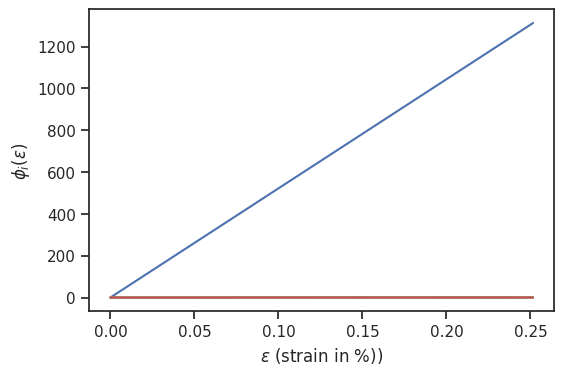

In [96]:
d = 4
eps = np.linspace(0, x.max(), 100)
print(eps.shape)
Phis = compute_design_matrix(eps, epsilon_l, d)
print(Phis.shape)
fig, ax = plt.subplots(dpi=100)
ax.plot(eps, Phis)
ax.set_xlabel('$\epsilon$ (strain in %))')
ax.set_ylabel('$\phi_i(\epsilon)$');

### Subpart B.III 

Fit the model using automatic relevance determination and demonstrate that it works well by doing all the things we did above (MSE, observations vs predictions plot, standarized errors, etc.).

In [97]:
# Your code here - Use as many blocks as you need!
from sklearn.linear_model import ARDRegression


Phis = compute_design_matrix(x_train, epsilon_l, d)

model = ARDRegression(
    fit_intercept=False,
    threshold_lambda=np.inf
).fit(Phis, y_train)




In [98]:
# Noise Variance  
sigma = np.sqrt(1.0 / model.alpha_)
print('sigma = {0:1.2f}'.format(sigma))

# Find coefficients 
m = model.coef_
print(f"Posterior mean w: {m}")

#Posterior Covariance 
S = model.sigma_
print(f"Posterior covariance w: {S}")

sigma = 31.41
Posterior mean w: [ 3.499e+01 -9.717e+04  3.686e+05 -4.512e+05]
Posterior covariance w: [[ 1.761e+01 -1.009e+04  7.137e+04 -1.533e+05]
 [-1.009e+04  7.102e+06 -4.570e+07  9.131e+07]
 [ 7.137e+04 -4.570e+07  3.072e+08 -6.344e+08]
 [-1.533e+05  9.131e+07 -6.344e+08  1.344e+09]]


Prior w precision: [2.357e+01 6.187e+04 1.247e+05 6.330e+04]


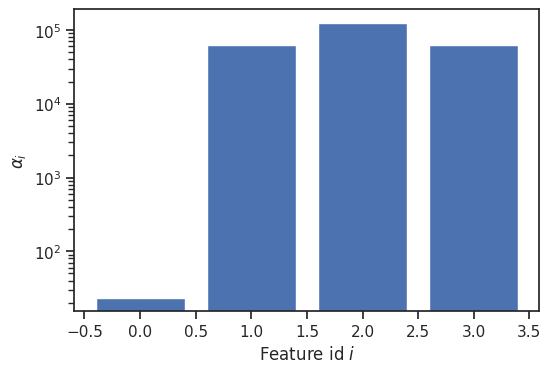

In [99]:
alpha = np.sqrt(1/model.lambda_)


print(f"Prior w precision: {alpha}")
fig, ax = plt.subplots()
ax.bar(np.arange(4), alpha)
ax.set_xlabel('Feature id $i$')
ax.set_ylabel(r'$\alpha_i$')
ax.set_yscale("log")


In [100]:
#MSE 
Phis = compute_design_matrix(x_train, epsilon_l, d)

Phi_test = compute_design_matrix(x_valid, epsilon_l, d)
#print(Phi_poly_test.shape)

y_test_predict = Phi_test @ m

mse = np.mean((y_test_predict - y_valid) ** 2)
print(f'MSE = {mse:1.2f}')

#Checks for me to see if the model is any good.
mu = y_train.mean()
MSE_simplest = np.mean((y_valid - mu) ** 2)
print(f'MSE_simplest = {MSE_simplest:1.2f}')
RMSE_poly = mse / MSE_simplest
print(f'RMSE_poly = {RMSE_poly:1.2f}')



MSE = 605.81
MSE_simplest = 3474.81
RMSE_poly = 0.17


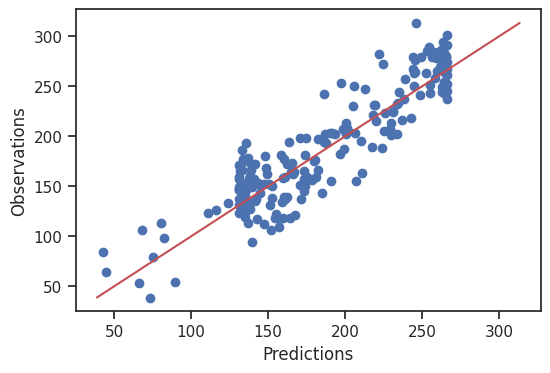

In [101]:
#Observations vs Predictions 
y_predict, y_std = model.predict(
    Phi_test,
    return_std=True)

#Plotting 
fig, ax = plt.subplots()
ax.plot(y_predict, y_valid, 'o')
yys = np.linspace(
    y_valid.min(),
    y_valid.max(),
    100)
ax.plot(yys, yys, 'r-')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

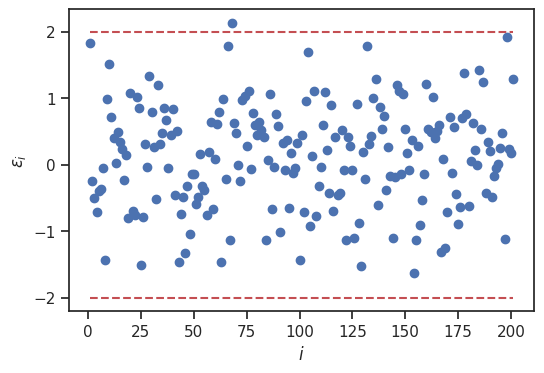

In [102]:
#Standardized Errors 
eps = (y_valid - y_predict) / y_std

idx = np.arange(1, eps.shape[0] + 1)

fig, ax = plt.subplots()
ax.plot(idx, eps, 'o', label='Standarized errors')
ax.plot(idx, -2 * np.ones(eps.shape[0]), 'r--')
ax.plot(idx, 2 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$');

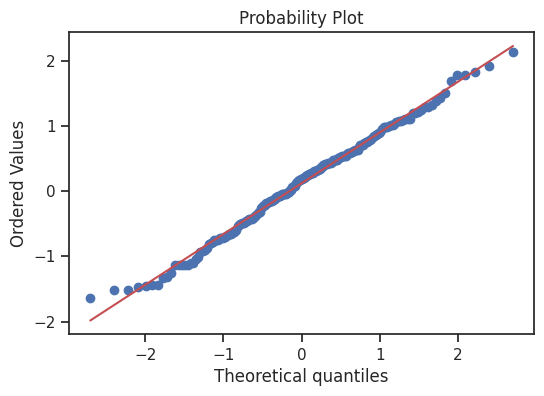

In [103]:
# Quantile-Quantile Plot 
fig, ax = plt.subplots()
st.probplot(eps, dist=st.norm, plot=ax);

### Subpart B.IV
Visualize epistemic and aleatory uncertainty in the stess-strain relation.

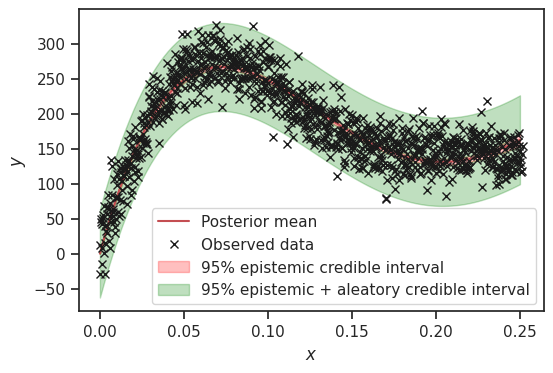

In [104]:
# Your code here
# your code here
# 14_4 example code?
xx = np.linspace(-0, .25, 100)
#Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
Phi_xx = compute_design_matrix(xx, epsilon_l, d)

# Predict with model
yy_mean, yy_measured_std = model.predict(
    Phi_xx,
    return_std=True
)

# Extract epistemic predictive standard deviation
yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
# Epistemic 95% credible interval
yy_le = yy_mean - 2.0 * yy_std
yy_ue = yy_mean + 2.0 * yy_std

# Epistemic + aleatory 95% credible interval
yy_lae = yy_mean - 2.0 * yy_measured_std
yy_uae = yy_mean + 2.0 * yy_measured_std

# The true response
# yy_true = w0_true + w1_true * xx + w2_true * xx ** 2

# Plot
fig, ax = plt.subplots()
ax.plot(xx, yy_mean, 'r', label="Posterior mean")
ax.fill_between(
    xx,
    yy_le,
    yy_ue,
    color='red',
    alpha=0.25,
    label="95% epistemic credible interval"
)
ax.fill_between(
    xx,
    yy_lae,
    yy_le,
    color='green',
    alpha=0.25
)
ax.fill_between(
    xx,
    yy_ue,
    yy_uae,
    color='green',
    alpha=0.25,
    label="95% epistemic + aleatory credible interval"
)
#Which Data should I use? All
ax.plot(x1, y1, 'kx', label='Observed data')
# ax.plot(xx, yy_true, "--", label="True response")
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc="best");

### Subpart B.V - Extract the ultimate strength

Now, you are going to quantify your epistemic uncertainty about the ultimate strength.
The ultimate strength is the maximum of the stress-strain relationship.
Since you have epistemic uncertainty about the stress-strain relationship, you also have epistemic uncertainty about the ultimate strength.

Do the following:
- Visualize posterior of the ultimate strength.
- Find a 95% credible interval for the ultimate strength.
- Pick a value for the ultimate strength.

**Hint:**
To characterize your epistemic uncertainty about the ultimate strength, you would have to do the following:
- Define a dense set of strain points between 0 and 0.25.
- Repeatedly:
    + sample from the posterior of the weights of your model
    + for each sample evaluate the stresses at the dense set of strain points defined earlier
    + for each sampled stress vector, find the maximum. This is a sample of the ultimate strength.

266.57595921309985
[0.073]
(4,)
(4, 4)


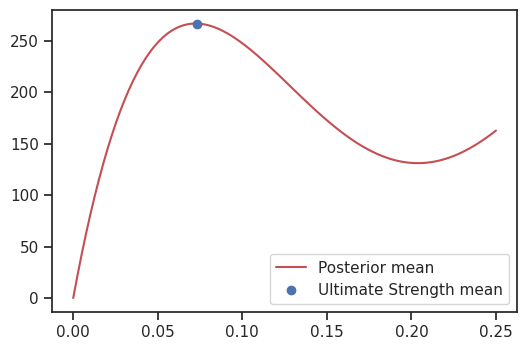

In [105]:
# Enter your code here
# Visualize posterior of ultimate strength 
fig, ax = plt.subplots()
max = np.amax(yy_mean)
index = np.where(yy_mean == max)
loc = xx[index[0]]

print(max)
print(loc)
ax.plot(xx, yy_mean, 'r', label="Posterior mean")
ax.plot(loc, max, 'o', label = 'Ultimate Strength mean')
plt.legend(loc="best")

print(m.shape)
print(S.shape)


# Need to add small number to covariance I think 
#Some Random Samples 
#w_post = st.multivariate_normal(mean=m, cov=S)

# Plotting 
#for _ in range(5):
#    w_sample = w_post.rvs()
#    yy_sample = Phi_test @ w_sample
#    ax.plot(xx, yy_sample, 'r', lw=0.5)
#ax.plot([], [], "r", lw=0.5, label="Posterior samples")
#plt.legend(loc="best");

In [106]:
# 95% Credible Interval for Ultimate Strength found from Epistemic Uncertainty 
# Lower 
maxl = np.amax(yy_le)
indexl = np.where(yy_mean == maxl)
locl = xx[indexl[0]]

# Upper 
maxu = np.amax(yy_ue)
indexu = np.where(yy_mean == maxu)
locu = xx[indexu[0]]

print(f'Credible Interval Ultimate Strength {maxl:.2f} to {maxu:.2f}')

Credible Interval Ultimate Strength 262.75 to 270.40


In [107]:
#Picking a value for Ultimate Strength 
print(f"Ultimate Strength = {max:.2f}")
print('This was chosen from the posterior mean of the model')

Ultimate Strength = 266.58
This was chosen from the posterior mean of the model


# Problem 2 - Optimizing the performance of a compressor

In this problem we are going to need [this](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/compressor_data.xlsx) dataset. The dataset was kindly provided to us by [Professor Davide Ziviani](https://scholar.google.com/citations?user=gPdAtg0AAAAJ&hl=en).
As before, you can either put it on your Google drive or just download it with the code segment below:

In [108]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/compressor_data.xlsx"
download(url)

Note that this is an Excell file, so we are going to need pandas to read it.
Here is how:

In [109]:
import pandas as pd
data = pd.read_excel('compressor_data.xlsx')
data

,T_e,DT_sh,T_c,DT_sc,T_amb,f,m_dot,m_dot.1,Capacity,Power,Current,COP,Efficiency
0,-30,11,25,8,35,60,28.8,8.000000,1557,901,4.4,1.73,0.467
1,-30,11,30,8,35,60,23.0,6.388889,1201,881,4.0,1.36,0.425
2,-30,11,35,8,35,60,17.9,4.972222,892,858,3.7,1.04,0.382
3,-25,11,25,8,35,60,46.4,12.888889,2509,1125,5.3,2.23,0.548
4,-25,11,30,8,35,60,40.2,11.166667,2098,1122,5.1,1.87,0.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,10,11,45,8,35,60,245.2,68.111111,12057,2525,11.3,4.78,0.722
61,10,11,50,8,35,60,234.1,65.027778,10939,2740,12.3,3.99,0.719
62,10,11,55,8,35,60,222.2,61.722222,9819,2929,13.1,3.35,0.709
63,10,11,60,8,35,60,209.3,58.138889,8697,3091,13.7,2.81,0.693


The data are part of a an experimental study of a variable speed reciprocating compressor.
The experimentalists varied two temperatures $T_e$ and $T_c$ (both in C) and they measured various other quantities.
Our goal is to learn the map between $T_e$ and $T_c$ and measured Capacity and Power (both in W).
First, let's see how you can extract only the relevant data.

In [110]:
# Here is how to extract the T_e and T_c columns and put them in a single numpy array
x = data[['T_e','T_c']].values
#x

In [111]:
# Here is how to extract the Capacity
y_c = data['Capacity'].values
y_p = data['Power'].values

print(y_p.shape)
# print(y_p.shape)

(65,)


Fit the following multivariate polynomial model to **both the Capacity and the Power**:

$$
y = w_1 + w_2T_e + w_3 T_c + w_4 T_eT_c + w_5 T_e^2 + w_6T_c^2 + w_7 T_e^2T_c + w_8T_eT_c^2 + w_9 T_e^3 + w_{10}T_c^3 + \epsilon,
$$

where $\epsilon$ is a Gaussian noise term with unknown variance.

**Hints:**
+ You may use [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to construct the design matrix of your polynomial features. Do not program the design matrix by hand.
+ You should split your data into training and validation and use various validation metrics to make sure that your models make sense.
+ Use [ARD Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ARDRegression.html#sklearn.linear_model.ARDRegression) to fit any hyperparameters and the noise.

### Subpart A.I - Fit the capacity

Please don't just fit blindly. Split in training and test and use all the usual diagnostics.

In [112]:
# your code here - Repeat as many text and code blocks as you like
from sklearn.preprocessing import PolynomialFeatures

x_train, x_valid, y_train, y_valid = train_test_split(x, y_c, test_size=0.20)


poly = PolynomialFeatures(3)
Phi = poly.fit_transform(x_train)

model = ARDRegression(
    fit_intercept=False,
    threshold_lambda=np.inf
).fit(Phi, y_train)



In [113]:
#Mean Square Error 

m = model.coef_

Phi_valid = poly.fit_transform(x_valid)
y_test_predict = Phi_valid @ m
mse = np.mean((y_test_predict - y_valid) ** 2)
print(f'MSE = {mse:1.2f}')


MSE = 0.09


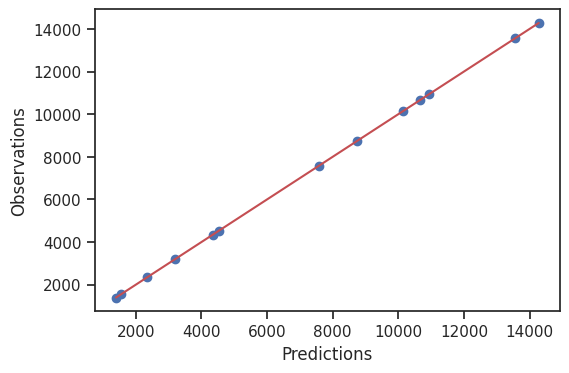

In [114]:
#Observations vs. Predictions 
Phi_valid = poly.fit_transform(x_valid)

y_predict, y_std = model.predict(
    Phi_valid,
    return_std=True)

#Plotting 
fig, ax = plt.subplots()
ax.plot(y_predict, y_valid, 'o')
yys = np.linspace(
    y_valid.min(),
    y_valid.max(),
    100)
ax.plot(yys, yys, 'r-')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');


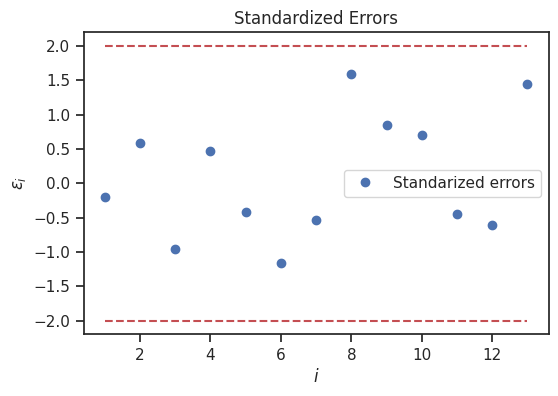

In [115]:
#Standardized Errors 
eps = (y_valid - y_predict) / y_std

idx = np.arange(1, eps.shape[0] + 1)

fig, ax = plt.subplots()
ax.plot(idx, eps, 'o', label='Standarized errors')
ax.plot(idx, -2 * np.ones(eps.shape[0]), 'r--')
ax.plot(idx, 2 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$')
ax.set_title('Standardized Errors')
plt.legend(loc="best");


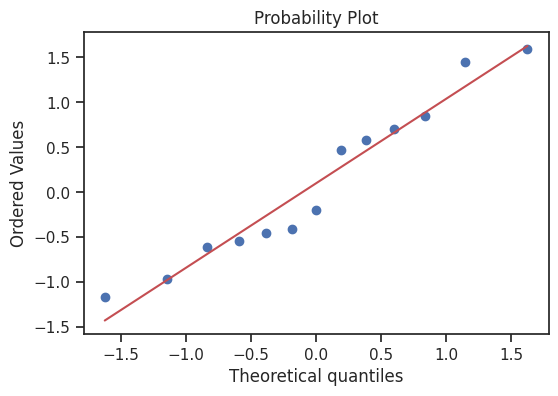

In [116]:
fig, ax = plt.subplots()
st.probplot(eps, dist=st.norm, plot=ax);

### Subpart A.II

What is the noise variance you estimated for the Capacity?

In [117]:
# your code here
sigma = np.sqrt(1.0 / model.alpha_)
print('sigma = {0:1.2f}'.format(sigma))

sigma = 0.32


### Subpart A.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Capacity?

Prior w precision: [4.304e-09 3.037e-06 3.480e-05 1.827e-02 1.141e-01 1.725e+02 1.549e+03
 5.719e+02 1.250e+03 1.633e+05]


Text(0.5, 1.0, 'Precision Weights')

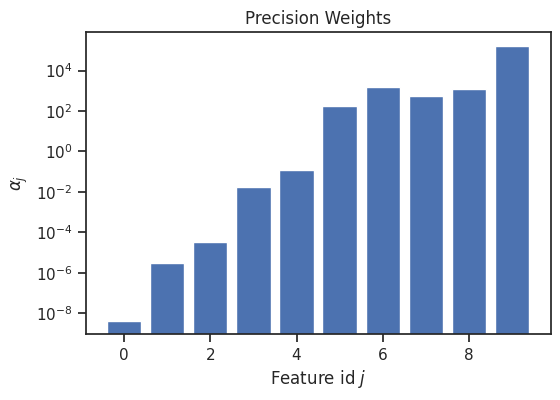

In [118]:
# your code here

alpha = model.lambda_
print(f"Prior w precision: {alpha}")

fig, ax = plt.subplots()
ax.bar(np.arange(10), alpha)
ax.set_xlabel('Feature id $j$')
ax.set_ylabel(r'$\alpha_j$')
ax.set_yscale("log")
ax.set_title('Precision Weights')


In [119]:
print("Features 5-9 are most important.\n Feature 1 through 5 have increasing importance with feature 0 being unimportant.\n This is shown in the plot above. I would personally include at least features 5-8")

Features 5-9 are most important.
 Feature 1 through 5 have increasing importance with feature 0 being unimportant.
 This is shown in the plot above. I would personally include at least features 5-8


In [120]:
print('Please not that there is an offset from the orginal functions hence:')
print('w6, w7, w8, w9, and w10 are the most important')

Please not that there is an offset from the orginal functions hence:
w6, w7, w8, w9, and w10 are the most important


### Subpart B.I - Fit the Power

Please don't just fit blindly. Split in training and test and use all the usual diagnostics.

In [121]:
# your code here - Repeat as many text and code blocks as you like
#Splitting data set 
x_train, x_valid, y_train, y_valid = train_test_split(x, y_p, test_size=0.20)

poly = PolynomialFeatures(3)
Phi = poly.fit_transform(x_train)

model = ARDRegression(
    fit_intercept=False,
    threshold_lambda=np.inf
).fit(Phi, y_train)



In [122]:
#Mean Square Error 

m = model.coef_
#

Phi_valid = poly.fit_transform(x_valid)
y_test_predict = Phi_valid @ m
mse = np.mean((y_test_predict - y_valid) ** 2)
print(f'MSE = {mse:1.2f}')


MSE = 0.10


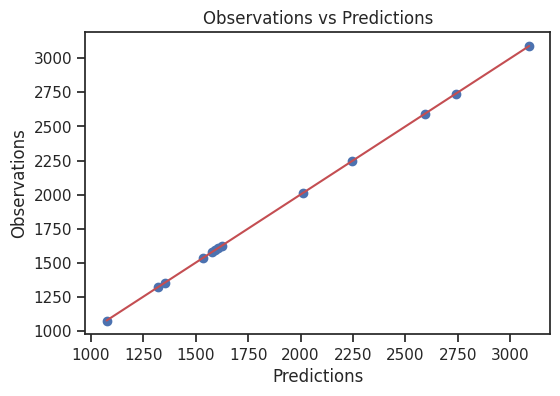

In [123]:
#Observations vs Predictions 
Phi_valid = poly.fit_transform(x_valid)

y_predict, y_std = model.predict(
    Phi_valid,
    return_std=True)

#Plotting 
fig, ax = plt.subplots()
ax.plot(y_predict, y_valid, 'o')
yys = np.linspace(
    y_valid.min(),
    y_valid.max(),
    100)
ax.plot(yys, yys, 'r-')
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
ax.set_title('Observations vs Predictions');

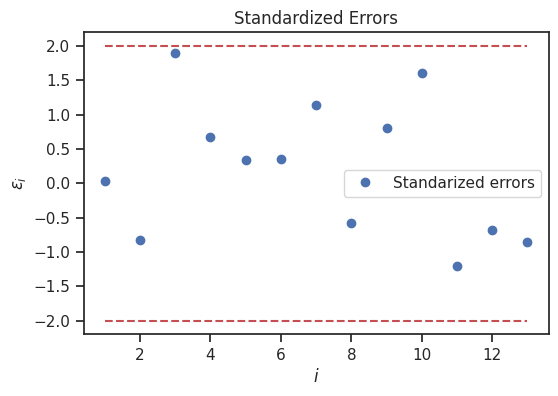

In [124]:
#Standardized Errors 
eps = (y_valid - y_predict) / y_std

idx = np.arange(1, eps.shape[0] + 1)

fig, ax = plt.subplots()
ax.plot(idx, eps, 'o', label='Standarized errors')
ax.plot(idx, -2 * np.ones(eps.shape[0]), 'r--')
ax.plot(idx, 2 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$')
ax.set_title('Standardized Errors')
plt.legend(loc="best");


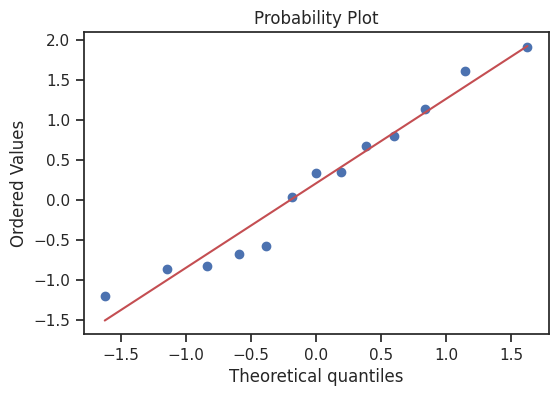

In [125]:
fig, ax = plt.subplots()
st.probplot(eps, dist=st.norm, plot=ax);

### Subpart B.II

What is the noise variance you estimated for the Power?

In [126]:
# your code here
# your code here
sigma = np.sqrt(1.0 / model.alpha_)
print('sigma = {0:1.2f}'.format(sigma))

sigma = 0.29


### Subpart B.III
Which features of the temperatures (basis functions of your model) are the most important for predicting the Power?

Prior w precision: [2.803e-06 2.314e-04 4.667e-04 2.301e-01 1.535e-01 1.308e+02 7.196e+03
 1.420e+03 1.650e+04 1.333e+05]


Text(0.5, 1.0, 'Precision Weights')

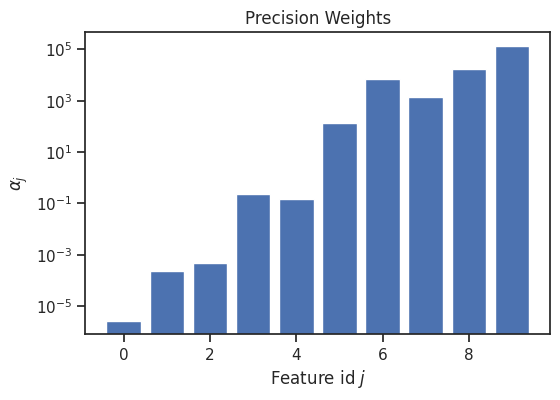

In [127]:
# your code here
alpha = model.lambda_
print(f"Prior w precision: {alpha}")

fig, ax = plt.subplots()
ax.bar(np.arange(10), alpha)
ax.set_xlabel('Feature id $j$')
ax.set_ylabel(r'$\alpha_j$')
ax.set_yscale("log")
ax.set_title('Precision Weights')

In [128]:
# Features
print('As shown in the graph above, \n Features 5-8 are most important with 3 and 4 being less important. Features 0-2 have minimal effect.')

As shown in the graph above, 
 Features 5-8 are most important with 3 and 4 being less important. Features 0-2 have minimal effect.


In [129]:
print('Please not that there is an offset from the orginal functions hence:')
print('w6, w7, w8, w9, and w10 are the most important')

Please not that there is an offset from the orginal functions hence:
w6, w7, w8, w9, and w10 are the most important


# Problem 3 - Explaining the challenger disaster
On January 28, 1986, the [Space Shuttle Challenger](https://en.wikipedia.org/wiki/Space_Shuttle_Challenger_disaster) disintegrated after 73 seconds from launch.
The failure can be traced on the rubber O-rings which were used to seal the joints of the solid rocket boosters (required to force the hot, high-pressure gases generated by the burning solid propelant through the nozzles thus producing thrust).

It turns out that the performance of the O-ring material was particularly sensitive on the external temperature during launch.
This [dataset](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/homework/challenger_data.csv) contains records of different experiments with O-rings recorded at various times between 1981 and 1986.
Download the data the usual way (either put them on Google drive or run the code cell below).

In [130]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/challenger_data.csv"
download(url)

Even though this is a csv file, you should load it with pandas because it contains some special characters.

In [131]:
raw_data = pd.read_csv('challenger_data.csv')
raw_data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,6/27/82,80,NaN
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1


The first column is the date of the record. The second column is the external temperature of that day in degrees F.
The third column labeled ``Damage Incident`` is has a binary coding (0=no damage, 1=damage).
The very last row is the day of the Challenger accident.

We are going to use the first 23 rows to solve a binary classification problem that will give us the probability of an accident conditioned on the observed external temperature in degrees F. Before we proceed to the analysis of the data, let's clean the data up.

First, we drop all the bad records:

In [132]:
clean_data_0 = raw_data.dropna()
clean_data_0

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


We also don't need the last record. Just remember that the temperature the day of the Challenger accident was 31 degrees F.

In [133]:
clean_data = clean_data_0[:-1]
clean_data

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


Let's extract the features and the labels:

In [134]:
x = clean_data['Temperature'].values
x.shape

(23,)

In [135]:
y = clean_data['Damage Incident'].values.astype(np.float)
y.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


(23,)

## Part A - Perform logistic regression

Perform logistic regression between the temperature ($x$) and the damage label ($y$).
Do not bother doing a validation because there are not a lot of data.
Just use a very simple model so that you don't overfit.

In [136]:
# your code here - Repeat as many text and code blocks as you like

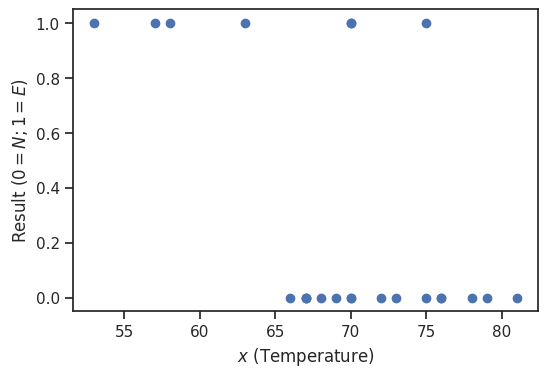

In [137]:
#Visualization - Just for me 
fig, ax = plt.subplots()
ax.plot(x, y, 'o')
ax.set_xlabel('$x$ (Temperature)')
ax.set_ylabel('Result ($0=N; 1=E$)');

In [138]:
#Fitting Model 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

# Design matrix - Simple as to not overfit (linear model)
poly = PolynomialFeatures(1)
Phi = poly.fit_transform(x[:, None])

# Fit
model = LogisticRegression(
    penalty='none',
    fit_intercept=False
).fit(Phi, y)

In [139]:
model.coef_


array([[15.043, -0.232]])

## Part B - Plot the probability of damage as a function of temperature
Plot the probability of damage as a function of temperature.

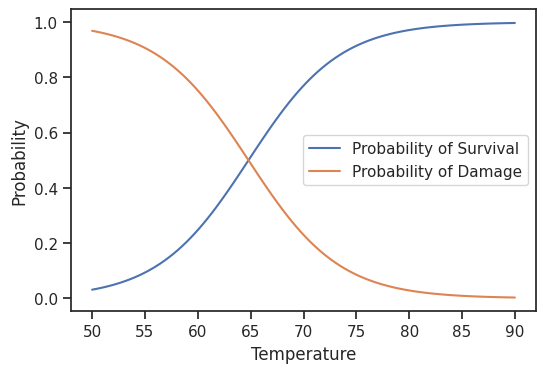

In [140]:
# your code here

fig, ax = plt.subplots()
xx = np.linspace(50, 90, 100)
Phi_xx = poly.fit_transform(xx[:, None])
predictions_xx = model.predict_proba(Phi_xx)
ax.plot(
    xx,
    predictions_xx[:, 0],
    label='Probability of Survival'
)
ax.plot(
    xx,
    predictions_xx[:, 1],
    label='Probability of Damage'
)
ax.set_xlabel('Temperature')
ax.set_ylabel('Probability')
plt.legend(loc='best');

## Part C - Decide whether or not to launch

The temperature the day of the Challenger accident was 31 degrees F.
Start by calculating the probability of damage at 31 degrees F.
Then, use formal decision-making (i.e., define a cost matrix and make decisions by minimizing the expected loss) to decide whether or not to launch on that day.
Also, plot your optimal decision as a function of the external temperature.

Probability of Damage @ 31 degrees = 0.99961
Cost of Damage: 0.99969
Cost of Survival: 0.00310
Taking into account the high probability of damage, and high cost of damage, I WOULD NOT LAUNCH


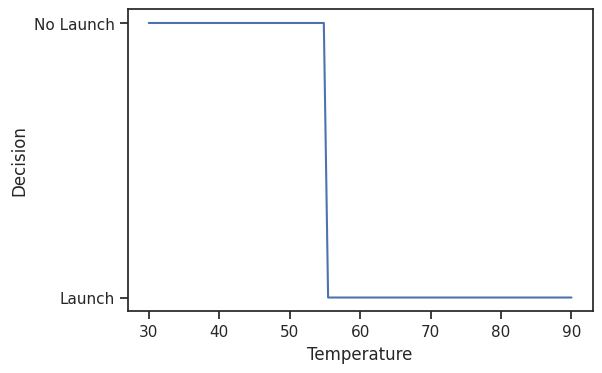

In [141]:
# your code here - Repeat as many text and code blocks as you like
#p(damage @ 31 degrees F )
xx_31 = np.linspace(31, 32, 1)
# print(xx_31)
Phi_31 = poly.fit_transform(xx_31[:, None])
predictions_xx = (model.predict_proba(Phi_31))[0,1]
print(f'Probability of Damage @ 31 degrees = {predictions_xx:.5f}')

#loc = np.where(xx == 30)
#p_damage = predictions_xx[loc, 1]
#print(p_damage)


#Formal Decision-making (cost matrix and minimize expected loss)
# 0 = Damage 
# 1 = Surivival and functional 

# c_00 = cost of correctly picking 0 when 0 is true
# c_01 = cost of wrongly picking 0 when 1 is true
# c_11 = cost of correctly picking 1 when 1 is true
# c_10 = cost of wrongly picking 1 when 0 is true


xx = np.linspace(30, 90, 100)
Phi = poly.fit_transform(xx[:, None])
predictions = model.predict_proba(Phi)



cost_matrix = np.array(
    [
        [0.0, 1.0],
        [10.0, 0.0]
    ]
)

exp_cost = np.einsum('ij,kj->ki', cost_matrix, predictions)
# print(exp_cost[0,:])

print(f'Cost of Damage: {exp_cost[0,0]:.5f}')
print(f'Cost of Survival: {exp_cost[0,1]:.5f}')

print('Taking into account the high probability of damage, and high cost of damage, I WOULD NOT LAUNCH')

#Plot Optimal decision as a function of external temperature 

decision_idx = np.argmin(exp_cost, axis=1)

fig, ax = plt.subplots()
ax.plot(xx, decision_idx)
# print(decision_idx)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Launch', 'No Launch'])
ax.set_ylabel('Decision')
ax.set_xlabel('Temperature');

In [142]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('MihirNadig_homework-04.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.



MessageError: ignored